In [ ]:
!pip install category_encoders
!pip install streamlit
!pip install optuna
!pip install lime
import streamlit as st
import kagglehub
import pandas as pd
import numpy as np
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap
import joblib
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from category_encoders import TargetEncoder
from sklearn.feature_selection import RFE
import optuna
import lime
import lime.lime_tabular
import warnings
warnings.filterwarnings('ignore')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b3be75c80686a7deb2ae49019973ec97fa8e84f63422c8663c02990eb598dcd4
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
# Download Dataset
path = kagglehub.dataset_download("marcopale/housing")
print("Dataset downloaded at:", path)

# Extract dataset if it's a ZIP file
if path.endswith(".zip"):
    with zipfile.ZipFile(path, 'r') as zip_ref:
        extract_path = path.replace(".zip", "")
        zip_ref.extractall(extract_path)
        path = extract_path

# Find train.csv explicitly
def find_train_csv(directory):
    for file in os.listdir(directory):
        if file == "train.csv":
            return os.path.join(directory, file)
    return None

data_path = find_train_csv(path)
if data_path:
    print("CSV file found:", data_path)
    df = pd.read_csv(data_path)
    print("Data Preview:")
    print(df.head())
else:
    print("train.csv not found in directory:", path)
    print("Available files:", os.listdir(path))
    exit()

# Check that dataset has expected columns
expected_cols = ['SalePrice', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Garage Area',
                 'Yr Sold', 'Year Built', 'Year Remod/Add', 'Overall Qual', 'Gr Liv Area']
missing_cols = [col for col in expected_cols if col not in df.columns]
if missing_cols:
    print(f"Error: Dataset missing expected columns: {missing_cols}")
    print("Proceeding with available numerical columns, but results may be suboptimal.")
else:
    print("All expected columns found.")

# Initial Data Exploration
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())
print("\nSkewness of SalePrice:", df['SalePrice'].skew())

100%|██████████| 397k/397k [00:00<00:00, 556kB/s]

Extracting files...


Dataset downloaded at: /root/.cache/kagglehub/datasets/marcopale/housing/versions/2
CSV file found: /root/.cache/kagglehub/datasets/marcopale/housing/versions/2/train.csv
Data Preview:
   Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0    534  531363010           20        RL          80.0      9605   Pave   
1    803  906203120           20        RL          90.0     14684   Pave   
2    956  916176030           20        RL           NaN     14375   Pave   
3    460  528180130          120        RL          48.0      6472   Pave   
4    487  528290030           80        RL          61.0      9734   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC Fence Misc Feature  \
0   NaN       Reg          Lvl  ...         0     NaN   NaN          NaN   
1   NaN       IR1          Lvl  ...         0     NaN   NaN          NaN   
2   NaN       IR1          Lvl  ...         0     NaN   NaN          NaN   
3   NaN       Reg          Lvl  ...         0   

In [ ]:
# Enhanced Feature Engineering
def create_features(df):
    df = df.copy()
    required_cols = ['Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Garage Area',
                     'Yr Sold', 'Year Built', 'Year Remod/Add', 'Overall Qual', 'Gr Liv Area']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"Warning: Skipping feature engineering due to missing columns: {missing_cols}")
        return df

    df['TotalSF'] = df['Total Bsmt SF'] + df['1st Flr SF'] + df['2nd Flr SF'] + df['Garage Area']
    df['Age'] = df['Yr Sold'] - df['Year Built']
    df['Remodeled'] = (df['Year Remod/Add'] > df['Year Built']).astype(int)
    df['Qual_LivArea'] = df['Overall Qual'] * df['Gr Liv Area']
    return df

df = create_features(df)

# Handle Missing Values with KNN Imputation
numeric_cols = df.select_dtypes(include=['number']).columns
if 'SalePrice' not in numeric_cols:
    print("Error: SalePrice not found in numeric columns. Exiting.")
    exit()
knn_imputer = KNNImputer(n_neighbors=5)
df[numeric_cols] = knn_imputer.fit_transform(df[numeric_cols])

# Fill categorical missing values with mode
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# Multivariate Outlier Detection with Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
outliers = iso_forest.fit_predict(df[numeric_cols])
df = df[outliers == 1]
print(f"Dataset size after multivariate outlier removal: {df.shape}")

# Log-transform SalePrice if skewed
is_log_transformed = False
if df['SalePrice'].skew() > 0.5:
    df['SalePrice'] = np.log1p(df['SalePrice'])
    is_log_transformed = True
    print("SalePrice log-transformed due to skewness.")

Dataset size after multivariate outlier removal: (1977, 86)
SalePrice log-transformed due to skewness.


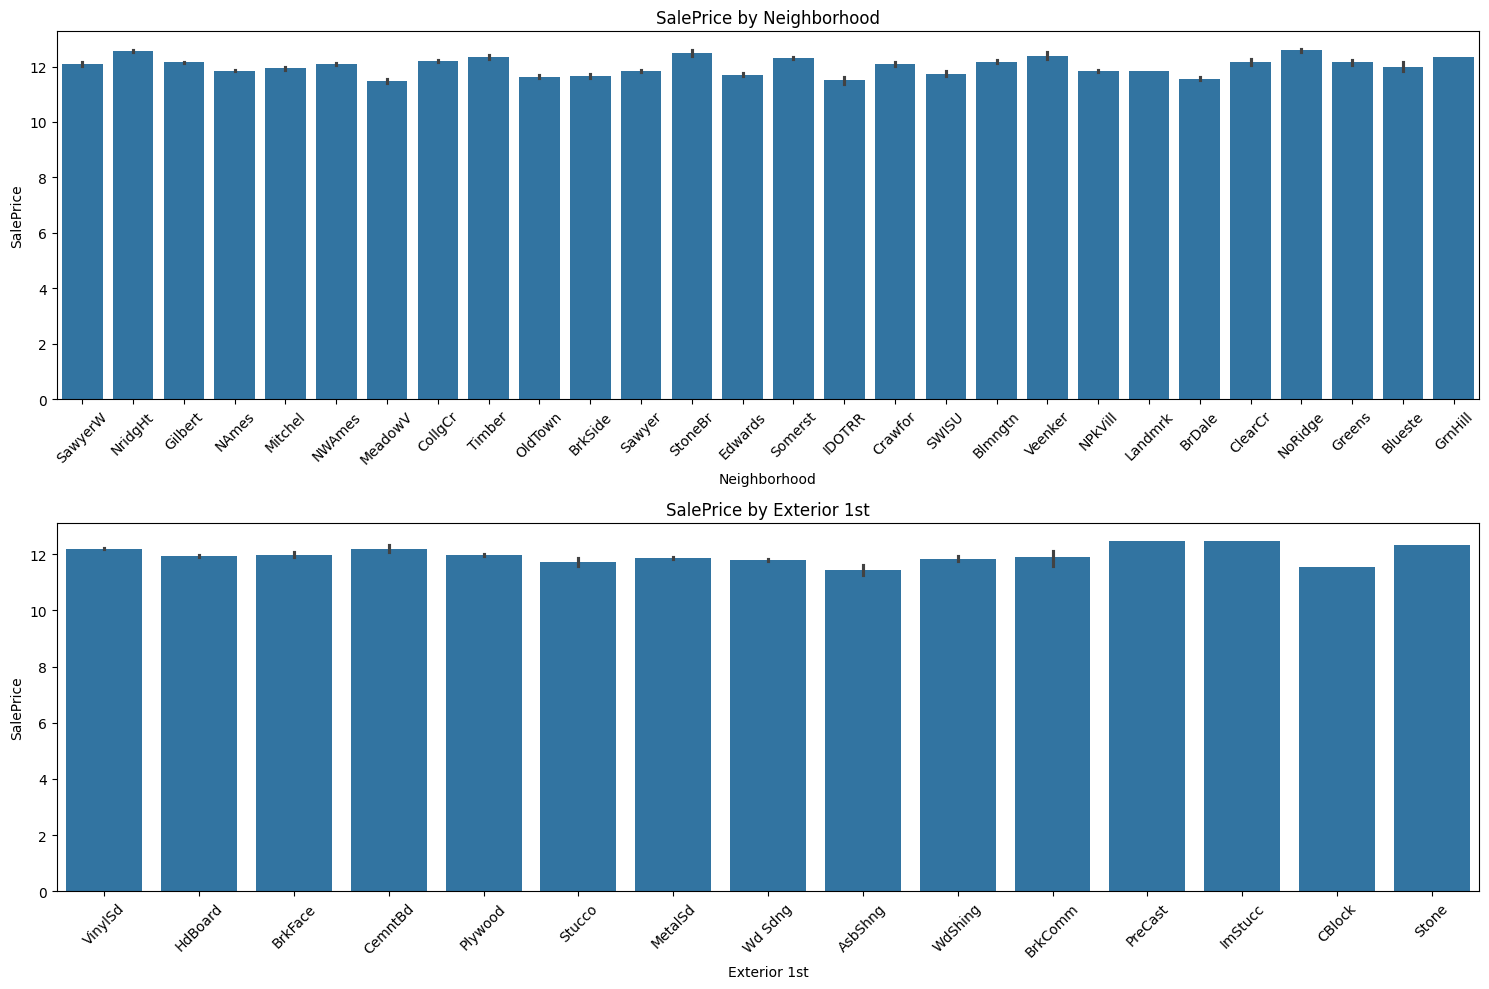

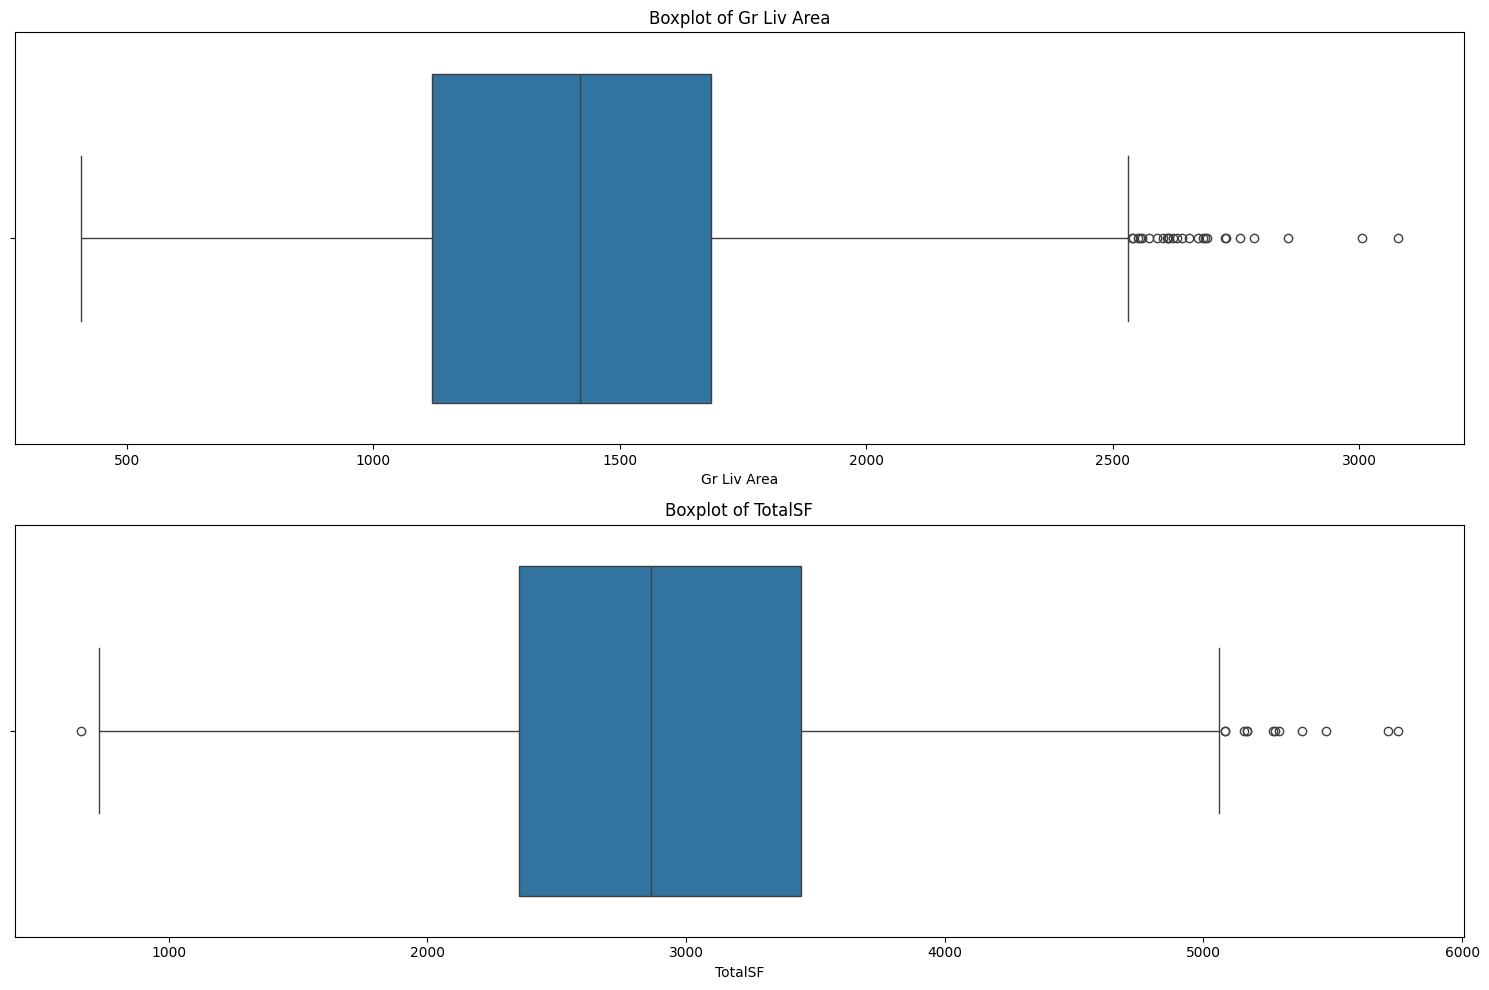


Training set size: 1581
Testing set size: 396


In [ ]:
# Enhanced EDA
plt.figure(figsize=(15, 10))
for i, col in enumerate(['Neighborhood', 'Exterior 1st'][:2], 1):
    if col in df.columns:
        plt.subplot(2, 1, i)
        sns.barplot(x=col, y='SalePrice', data=df)
        plt.xticks(rotation=45)
        plt.title(f'SalePrice by {col}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
for i, col in enumerate(['Gr Liv Area', 'TotalSF'][:2], 1):
    if col in df.columns:
        plt.subplot(2, 1, i)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# Split Data
df = df.sort_values('Yr Sold')
train_size = int(0.8 * len(df))
if len(df) - train_size < 100:
    train_size = int(0.7 * len(df))
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]
X_train = train_df.drop(columns=['SalePrice'])
y_train = train_df['SalePrice']
X_test = test_df.drop(columns=['SalePrice'])
y_test = test_df['SalePrice']

print(f'\nTraining set size: {X_train.shape[0]}')
print(f'Testing set size: {X_test.shape[0]}')

In [ ]:
# Encoding Categorical Variables
categorical_cols = X_train.select_dtypes(include=['object']).columns
high_cardinality_cols = [col for col in categorical_cols if X_train[col].nunique() > 10]
low_cardinality_cols = [col for col in categorical_cols if col not in high_cardinality_cols]

if low_cardinality_cols:
    from sklearn.preprocessing import OneHotEncoder
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoded_train = pd.DataFrame(encoder.fit_transform(X_train[low_cardinality_cols]),
                                 index=X_train.index)
    encoded_test = pd.DataFrame(encoder.transform(X_test[low_cardinality_cols]),
                                index=X_test.index)
    encoded_train.columns = encoder.get_feature_names_out(low_cardinality_cols)
    encoded_test.columns = encoder.get_feature_names_out(low_cardinality_cols)
    X_train = X_train.drop(columns=low_cardinality_cols).join(encoded_train)
    X_test = X_test.drop(columns=low_cardinality_cols).join(encoded_test)

if high_cardinality_cols:
    target_encoder = TargetEncoder()
    X_train[high_cardinality_cols] = target_encoder.fit_transform(X_train[high_cardinality_cols], y_train)
    X_test[high_cardinality_cols] = target_encoder.transform(X_test[high_cardinality_cols])

# Feature Scaling
scaler = StandardScaler()
numeric_cols = X_train.select_dtypes(include=['number']).columns
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Feature Selection with RFE
n_features = X_train.shape[1]
n_select = max(1, min(50, n_features // 2))
rf_for_rfe = RandomForestRegressor(n_estimators=100, random_state=42)
rfe = RFE(estimator=rf_for_rfe, n_features_to_select=n_select)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)
selected_features = X_train.columns[rfe.support_].tolist()
print(f"Selected {len(selected_features)} features with RFE.")


In [ ]:
# Model Training and Evaluation
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred))) if not is_log_transformed else np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"\n{model_name} Results:")
    print(f'MAE: {mae:.4f}, MSE: {mse:.4f}, R-Squared: {r2:.4f}, MAPE: {mape:.2f}%, RMSLE: {rmsle:.4f}')
    return mae, mse, r2, mape, rmsle

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_rfe, y_train)
y_pred_lr = lr_model.predict(X_test_rfe)
evaluate_model(y_test, y_pred_lr, "Linear Regression")

# Random Forest with Pipeline
rf_pipeline = Pipeline([('rf', RandomForestRegressor(random_state=42))])

# Bayesian Optimization for Random Forest
def rf_objective(trial):
    params = {
        'rf__n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'rf__max_depth': trial.suggest_int('max_depth', 10, 50),
        'rf__min_samples_split': trial.suggest_int('min_samples_split', 2, 10)
    }
    rf_pipeline.set_params(**params)
    return -cross_val_score(rf_pipeline, X_train_rfe, y_train, cv=5, scoring='neg_mean_absolute_error').mean()

study = optuna.create_study(direction='minimize')
study.optimize(rf_objective, n_trials=20)

# Apply Best Parameters
best_params = {
    'rf__n_estimators': study.best_params['n_estimators'],
    'rf__max_depth': study.best_params['max_depth'],
    'rf__min_samples_split': study.best_params['min_samples_split']
}
rf_pipeline.set_params(**best_params)
rf_pipeline.fit(X_train_rfe, y_train)
y_pred_rf = rf_pipeline.predict(X_test_rfe)
evaluate_model(y_test, y_pred_rf, "Random Forest")
print("Best Random Forest Parameters:", study.best_params)

# XGBoost with Early Stopping
xgb_model = XGBRegressor(random_state=42, early_stopping_rounds=10)
xgb_model.fit(X_train_rfe, y_train, eval_set=[(X_test_rfe, y_test)], verbose=False)
y_pred_xgb = xgb_model.predict(X_test_rfe)
evaluate_model(y_test, y_pred_xgb, "XGBoost")

# Stacking Ensemble
estimators = [
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, random_state=42))
]
stack_model = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(n_estimators=50, random_state=42))
stack_model.fit(X_train_rfe, y_train)
y_pred_stack = stack_model.predict(X_test_rfe)
evaluate_model(y_test, y_pred_stack, "Stacking Model")

# Cross-Validation for Best Model
cv_scores = cross_val_score(rf_pipeline, X_train_rfe, y_train, cv=5, scoring="neg_mean_absolute_error")
print(f"\nCross-Validated MAE (Random Forest): {-cv_scores.mean():.4f}")

In [ ]:
# Feature Importance
importances = rf_pipeline.named_steps['rf'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("\nTop 10 Most Important Features (Random Forest):")
print(feature_importance_df.head(10))

# SHAP Analysis
explainer = shap.TreeExplainer(rf_pipeline.named_steps['rf'])
shap_values = explainer.shap_values(X_test_rfe)
shap.summary_plot(shap_values, X_test_rfe, plot_type="bar", max_display=10)
plt.title("Top 10 Feature Contributions (SHAP)")
plt.show()

# LIME for Individual Prediction
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train_rfe, feature_names=selected_features, mode='regression')
lime_exp = lime_explainer.explain_instance(X_test_rfe[0], rf_pipeline.predict)
try:
    lime_exp.show_in_notebook(show_table=True)
except:
    print("LIME explanation:")
    print(lime_exp.as_list())

# Visualizations
numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(20, 15))
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

plt.figure(figsize=(15, 12))
plt.scatter(y_test, y_pred_stack, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual SalePrice (Scaled)")
plt.ylabel("Predicted SalePrice (Scaled)")
plt.title("Predicted vs Actual SalePrice (Stacking Model)")
plt.show()

plt.figure(figsize=(15, 12))
residuals = y_test - y_pred_stack
plt.scatter(y_pred_stack, residuals, alpha=0.5)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot (Stacking Model)")
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Save Models
joblib.dump(rf_pipeline, 'best_rf_model.pkl')
joblib.dump(xgb_model, 'best_xgb_model.pkl')
joblib.dump(stack_model, 'best_stack_model.pkl')
print("\nModels saved: 'best_rf_model.pkl', 'best_xgb_model.pkl', 'best_stack_model.pkl'")

# VIF Analysis for Selected Features
vif_data = pd.DataFrame()
vif_data["Feature"] = selected_features
vif_data["VIF"] = [variance_inflation_factor(X_train_rfe, i) for i in range(X_train_rfe.shape[1])]
print(f'\nVIF for Features (Top 10): {(vif_data.sort_values(by="VIF", ascending=False).head(10))}')

# Save preprocessing artifacts
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(encoder, 'onehot_encoder.pkl')
joblib.dump(target_encoder, 'target_encoder.pkl')
joblib.dump(selected_features, 'selected_features.pkl')

print("\nSaved preprocessing artifacts: 'scaler.pkl', 'onehot_encoder.pkl', 'target_encoder.pkl', 'selected_features.pkl'")
print("Saved models: 'best_rf_model.pkl', 'best_xgb_model.pkl', 'best_stack_model.pkl'")

!mkdir -p streamlit_app

In [ ]:
import pandas as pd
import streamlit as st
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
import joblib

st.set_page_config(page_title="House Price Prediction", layout="wide")
st.title("House Price Prediction")
st.write("Enter house details to predict the sale price using a pre-trained XGBoost model.")

# Load pre-trained model and preprocessing artifacts
try:
    model = joblib.load('best_xgb_model.pkl')
    scaler = joblib.load('scaler.pkl')
    onehot_encoder = joblib.load('onehot_encoder.pkl')
    target_encoder = joblib.load('target_encoder.pkl')
    selected_features = joblib.load('selected_features.pkl')
except FileNotFoundError:
    st.error("Required files missing. Ensure 'best_xgb_model.pkl', 'scaler.pkl', 'onehot_encoder.pkl', 'target_encoder.pkl', and 'selected_features.pkl' are in the directory.")
    st.stop()

# Define input features for UI
input_features = [
    'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
    'BsmtFin SF 1', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area',
    'Garage Area', 'Yr Sold', 'Neighborhood', 'Exterior 1st', 'Exterior 2nd'
]

# Define categorical options
neighborhood_options = [
    'Names', 'CollgCr', 'OldTown', 'Edwards', 'Somerst', 'Gilbert', 'NridgHt',
    'Sawyer', 'NWAmes', 'SawyerW', 'BrkSide', 'Crawfor', 'Mitchel', 'NoRidge',
    'Timber', 'IDOTRR', 'ClearCr', 'StoneBr', 'SWISU', 'Blmngtn', 'MeadowV',
    'BrDale', 'Veenker', 'NPkVill', 'Blueste'
]

exterior_options = [
    'VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing', 'CemntBd',
    'Plywood', 'AsbShng', 'Stucco', 'BrkComm', 'AsphShn', 'Stone', 'ImStucc', 'CBlock'
]

# Input form in sidebar
st.sidebar.header("House Details")
with st.sidebar.form("house_form"):
    lot_area = st.number_input("Lot Area (sq ft)", min_value=0, value=9600, step=100)
    overall_qual = st.slider("Overall Quality (1-10)", min_value=1, max_value=10, value=6)
    overall_cond = st.slider("Overall Condition (1-10)", min_value=1, max_value=10, value=5)
    year_built = st.number_input("Year Built", min_value=1800, max_value=2025, value=2000)
    year_remod_add = st.number_input("Year Remodeled", min_value=1800, max_value=2025, value=2000)
    bsmtfin_sf_1 = st.number_input("Basement Finished Area (sq ft)", min_value=0.0, value=0.0, step=10.0)
    total_bsmt_sf = st.number_input("Total Basement Area (sq ft)", min_value=0.0, value=1000.0, step=10.0)
    first_flr_sf = st.number_input("1st Floor Area (sq ft)", min_value=0, value=1200, step=10)
    second_flr_sf = st.number_input("2nd Floor Area (sq ft)", min_value=0, value=0, step=10)
    gr_liv_area = st.number_input("Above Ground Living Area (sq ft)", min_value=0, value=1200, step=10)
    garage_area = st.number_input("Garage Area (sq ft)", min_value=0.0, value=400.0, step=10.0)
    yr_sold = st.number_input("Year Sold", min_value=2000, max_value=2025, value=2010)
    neighborhood = st.selectbox("Neighborhood", options=neighborhood_options, index=0)
    exterior_1st = st.selectbox("Exterior 1st", options=exterior_options, index=0)
    exterior_2nd = st.selectbox("Exterior 2nd", options=exterior_options, index=0)
    submit_button = st.form_submit_button("Predict Price")

# Preprocessing function
def preprocess_input(data):
    df = pd.DataFrame([data])

    # Feature engineering
    df['TotalSF'] = df['Total Bsmt SF'] + df['1st Flr SF'] + df['2nd Flr SF'] + df['Garage Area']
    df['Age'] = df['Yr Sold'] - df['Year Built']
    df['Qual_LivArea'] = df['Overall Qual'] * df['Gr Liv Area']
    df['Remodeled'] = (df['Year Remod/Add'] > df['Year Built']).astype(int)

    # Define columns
    numeric_cols = [
        'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
        'BsmtFin SF 1', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area',
        'Garage Area', 'Yr Sold', 'TotalSF', 'Age', 'Qual_LivArea', 'Remodeled'
    ]
    high_cardinality_cols = ['Neighborhood', 'Exterior 1st', 'Exterior 2nd']
    low_cardinality_cols = []

    # Imputation
    imputer = KNNImputer(n_neighbors=5)
    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

    # Target encoding
    df[high_cardinality_cols] = target_encoder.transform(df[high_cardinality_cols])

    # Scaling
    scaler_cols = [col for col in numeric_cols if col in df.columns]
    df[scaler_cols] = scaler.transform(df[scaler_cols])

    # Ensure all selected features are present
    for col in selected_features:
        if col not in df.columns:
            df[col] = 0

    # Select RFE features
    df = df[selected_features]

    return df

# Prediction logic
if submit_button:
    input_data = {
        'Lot Area': lot_area,
        'Overall Qual': overall_qual,
        'Overall Cond': overall_cond,
        'Year Built': year_built,
        'Year Remod/Add': year_remod_add,
        'BsmtFin SF 1': bsmtfin_sf_1,
        'Total Bsmt SF': total_bsmt_sf,
        '1st Flr SF': first_flr_sf,
        '2nd Flr SF': second_flr_sf,
        'Gr Liv Area': gr_liv_area,
        'Garage Area': garage_area,
        'Yr Sold': yr_sold,
        'Neighborhood': neighborhood,
        'Exterior 1st': exterior_1st,
        'Exterior 2nd': exterior_2nd
    }

    # Preprocess input
    try:
        processed_data = preprocess_input(input_data)
        st.write(f"Processed data shape: {processed_data.shape}")  # Debug output
        log_pred = model.predict(processed_data.values)[0]  # Ensure 2D input
        pred_price = np.expm1(log_pred)  # Inverse log-transform
        st.subheader("Prediction Result")
        st.success(f"Predicted House Price: ${pred_price:,.2f}")
        st.subheader("Input Summary")
        st.write(pd.DataFrame([input_data]))
    except Exception as e:
        st.error(f"Error during prediction: {str(e)}")

In [ ]:
import os

!pip install -q streamlit
!npm install localtunnel
!wget -q -O - ipv4.icanhazip.com # USE THIS OUTPUT (ex., '34.133.84.111') as the Tunnel Password if you are asked on the next page
!streamlit run streamlit_app/app.py & npx localtunnel --port 8501
